In [25]:
import pandas as pd
import numpy as np
from shared import demand as dmd
from shared import features
from shared.backtesting import train_test_iteration
import matplotlib.pyplot as plt

#### Ingest and preprocess total time series

We use differenced demand data for now. One area to explore would be to look at spot prediction, but does not seem promising.

In [2]:
# ingest dataset
df = dmd.create_ds()
df = df.loc['2017-01-01':].copy()

ts = df[df['product_category_name'] == 'total'].copy()
ts = ts[['demand']].diff()

ts = features.construct_features(ts, lag_upto=7, roll_upto=7)
ts = ts.dropna()

####  Define parameters for cross validation and model function

In [3]:
split_day = '2018-01-01'
horizon = 7
n_splits = 20

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

def get_model():
    pipe = Pipeline([
        ('scl', StandardScaler()),
        ('reg', LassoCV(alphas=[10 ** -x for x in range(5)], max_iter=1e4)),
         ])
    return pipe

Helper functions for reconstructing the demand series from their differenced form.

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error
def get_metrics(y, y_pred):
    
    metrics = {'mae':mean_absolute_error(y, y_pred),
                'r2_score':r2_score(y, y_pred)}
    y.plot()
    y_pred.plot()
    plt.legend(['pred','true'])
    return metrics

def reconstruct_series(preds, horizon):
    preds['demand'] = preds['true'].cumsum()
    period_sum = preds['pred'].rolling(horizon).sum()
    preds['demand_pred'] = preds['demand'].shift(horizon) + period_sum
    return preds

{'mae': 30.84370831567998, 'r2_score': 0.4580567728559244}

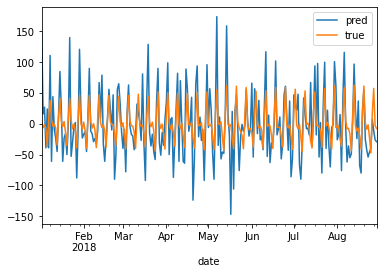

In [6]:
trained, metrics, preds = train_test_iteration(ts, get_model, split_day=split_day, horizon=horizon, 
                     n_splits=n_splits)

get_metrics(preds['true'], preds['pred'])

Not much beyond the weekly pattern is catched by the model.

The more important thing is to look at the actual demand series reconstructed from the forecasted differences.

{'mae': 50.67589287450164, 'r2_score': 0.09561850061291943}

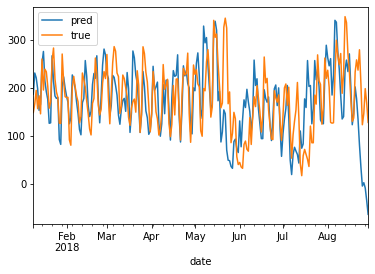

In [7]:
reconstruct_series(preds, horizon)
get_metrics(preds.dropna()['demand'], preds.dropna()['demand_pred'])

#### Random forest

In [8]:
def get_rf():
    return RandomForestRegressor(n_estimators=(300))

In [9]:
trained, metrics, preds = train_test_iteration(ts, get_rf, split_day=split_day, horizon=horizon, 
                     n_splits=n_splits)

{'mae': 31.15990277777778, 'r2_score': 0.44015372316495704}

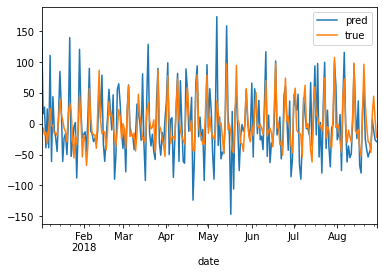

In [10]:
get_metrics(preds['true'], preds['pred'])

{'mae': 58.15869814020027, 'r2_score': -0.1215917170940164}

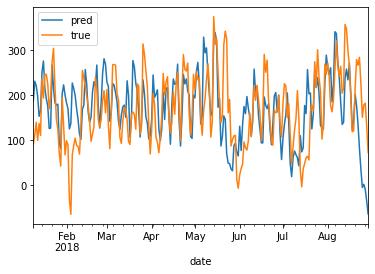

In [11]:
reconstruct_series(preds, horizon)
get_metrics(preds.dropna()['demand'], preds.dropna()['demand_pred'])

The default parameter underperforms a simple LASSO. 
We could experiment further with model specifications but the linear model will do for now.

### Run across diferent product categories

In [31]:
categories = df['product_category_name'].unique()
categories = categories[categories != 'total']

In [69]:
def filter_prep_by_category(df, category):
    ts = df[df['product_category_name'] == category].copy()
    ts = ts[['demand']].diff()
    ts = features.construct_features(ts, lag_upto=7, roll_upto=7)
    ts = ts.dropna()
    return ts

Rerun for ts and backfill.

In [71]:
ts = filter_prep_by_category(df, 'total')

In [72]:
trained, metrics, preds = train_test_iteration(ts, get_model, split_day=split_day, horizon=horizon, 
                     n_splits=n_splits, plot=True)

In [73]:
predicted_total = preds[['pred']].reindex(ts.index)

predicted_backfill = trained.predict(ts.drop('demand', 1).values)
predicted_backfill = pd.Series(predicted_backfill, index=ts.index, name='backfill')
predicted_total = predicted_total.join(predicted_backfill, how='left')
predicted_total = predicted_total['pred'].fillna(predicted_total['backfill'])

Run for each category

In [91]:
def run_for_category(df, category, totals=None):
    traineds = {}
    metrics = {}
    this_ts = filter_prep_by_category(df, category)
    if totals is not None:
        # add predicted total as a feature
        this_ts = this_ts.join(totals, how='left', rsuffix='_pred_total')
        
    trained, metrics, preds = train_test_iteration(this_ts, get_model, split_day=split_day, horizon=horizon, 
                     n_splits=n_splits, plot=False)
    return {'model':trained, 'metrics':metrics}

In [ ]:
import warnings
results = {}
for cat in categories:
    results[cat] = run_for_category(df, cat, totals=None)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. 